In [64]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.stats import pearsonr
from scipy.spatial import distance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.signal as signal
from causality import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from matplotlib import rc

# 设置全局字体为Times New Roman
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})


# case 1

In [2]:
def func_1(x, y, r, beta):
    return x * (r - r * x - beta * y)

In [3]:
# generate data
r_x = 3.8
r_y = 3.5
beta_xy = 0.0 # effect on x given y (effect of y on x)
beta_yx = 0.1 # effect on y given x (effect of x on y)

x0 = 0.4 # initial val
y0 = 0.2 # initial val
t = 1000 # time steps

x = [x0]
y = [y0]
for i in range(t):
    x_ = func_1(x[-1], y[-1], r_x, beta_xy)
    y_ = func_1(y[-1], x[-1], r_y, beta_yx)    
    x.append(x_)
    y.append(y_) 

In [4]:
df = pd.DataFrame({"X":x,"Y":y})
stt = StationaryTest(df)
stt.adf_test()

Tips: p > 0.05 or Test statistic > Critical value, implies trend is stationary can be rejected


X       Y
Test statistic       -17.0701 -7.7006
p-value                0.0000  0.0000
Critical value - 1%   -3.4369 -3.4371
Critical value - 5%   -2.8645 -2.8645
Critical value - 10%  -2.5683 -2.5683

In [5]:
stt.kpss_test()

Tips: p < 0.05 or Test statistic > Critical value, implies trend is stationary can be rejected


X       Y
Test statistic         0.081  0.0164
p-value                0.100  0.1000
Critical value - 1%    0.216  0.2160
Critical value - 2.5%  0.176  0.1760
Critical value - 5%    0.146  0.1460
Critical value - 10%   0.119  0.1190

AIC     25
BIC      8
HQIC    11
FPE     25
dtype: int64


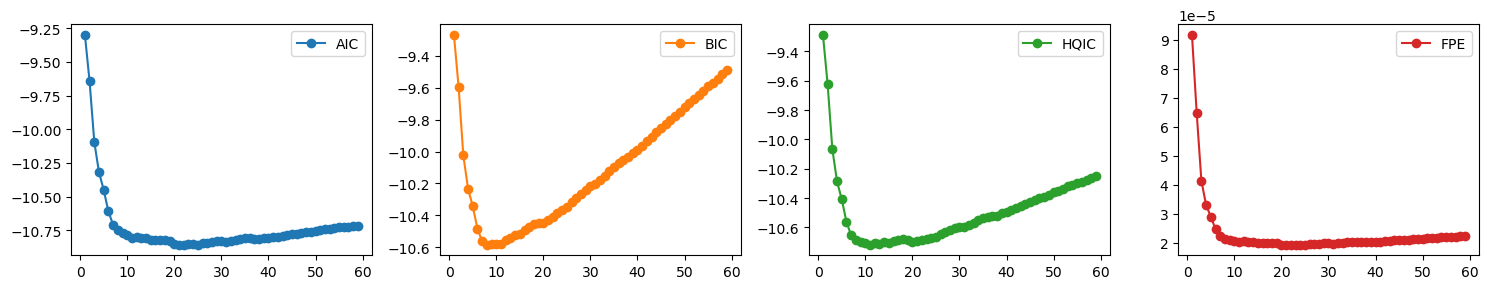

In [6]:
select_lag(df)

In [7]:
gct = GrangerCausality(df,8)
gct.granger_causation_matrix()

Tips: p<0.05, implies the x does not cause y can be rejected


X_x     Y_x
X_y  1.0  0.0337
Y_y  0.0  1.0000

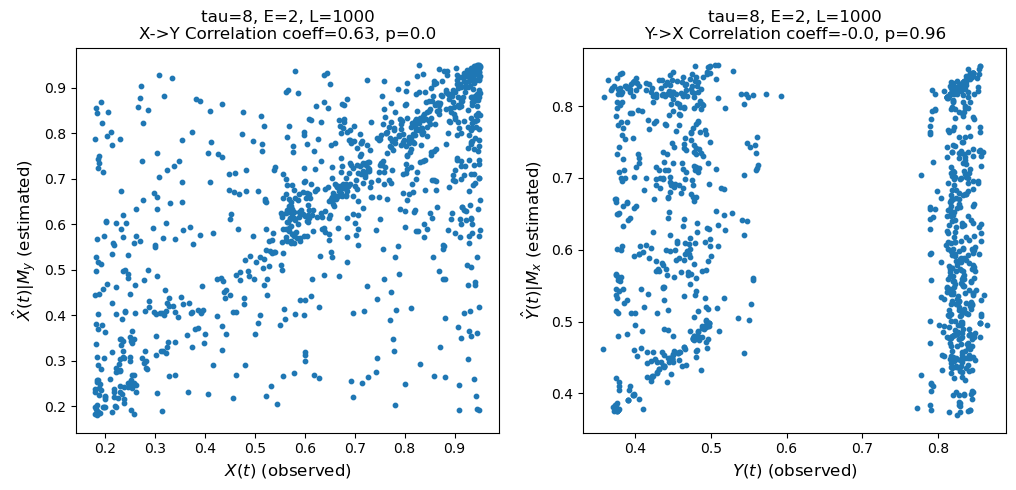

In [8]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 8 # time lag
E = 2 # shadow manifold embedding dimensions
L = 1000 # length of time period to consider

ccm = ConvergentCrossMapping(x, y, tau, E, L)
ccm.plot_ccm_correls()

Tips: p < 0.05, implies the x does not cause y can be rejected
X->Y r 0.63 p value 0.0
Y->X r 0.01 p value 0.67


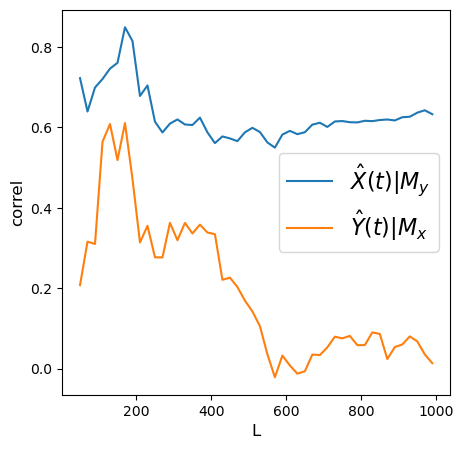

In [9]:
ccm.plot_convergence()

In [10]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5647,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.1443,
 'CriticalValue(0.05)': 0.1366,
 'CriticalValue(0.10)': 0.1326}

In [11]:
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.1282,
 'p_value': 0.9999,
 'CriticalValue(0.01)': 0.2206,
 'CriticalValue(0.05)': 0.21,
 'CriticalValue(0.10)': 0.2044}

In [12]:
te.cte_xyz(y, x, x)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.2584,
 'CriticalValue(0.05)': 0.2505,
 'CriticalValue(0.10)': 0.2463}

# case 2

In [13]:
def func_2(x, y, alpha, beta, noise):
    x_ = 1 - alpha*x*x + 0.02*noise[0]
    y_ = beta*x + 0.01*noise[1]
    return x_, y_

In [14]:
# generate data
alpha = 1.4
beta = 0.3

x0 = 0.0
y0 = 0.0
t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,2))

x = [x0]
y = [y0]
for i in range(t):
    x_, y_ = func_2(x[-1], y[-1], alpha, beta, noise[i])  
    x.append(x_)
    y.append(y_) 

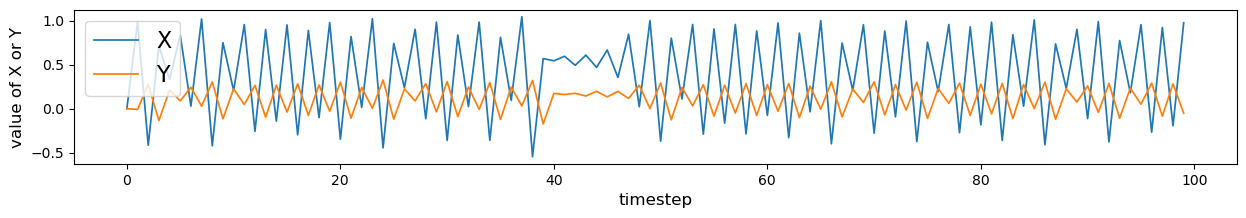

In [15]:
plt.figure(figsize=(15,2))
max_t = 100
plt.plot(x[:max_t], linewidth=1.25, label='X')
plt.plot(y[:max_t], linewidth=1.25, label='Y')
plt.xlabel('timestep', size=12)
plt.ylabel('value of X or Y', size=12)
plt.legend(prop={'size': 16})

In [16]:
df = pd.DataFrame({"X":x,"Y":y})
stt = StationaryTest(df)
stt.adf_test()

Tips: p > 0.05 or Test statistic > Critical value, implies trend is stationary can be rejected


X       Y
Test statistic       -7.7771 -7.5067
p-value               0.0000  0.0000
Critical value - 1%  -3.4371 -3.4370
Critical value - 5%  -2.8645 -2.8645
Critical value - 10% -2.5683 -2.5683

In [17]:
stt.kpss_test()

Tips: p < 0.05 or Test statistic > Critical value, implies trend is stationary can be rejected


X       Y
Test statistic         0.0175  0.0122
p-value                0.1000  0.1000
Critical value - 1%    0.2160  0.2160
Critical value - 2.5%  0.1760  0.1760
Critical value - 5%    0.1460  0.1460
Critical value - 10%   0.1190  0.1190

In [18]:
select_lag(df)

AIC     50
BIC      6
HQIC     8
FPE     50
dtype: int64


In [19]:
gct = GrangerCausality(df,6)
gct.granger_causation_matrix()

Tips: p<0.05, implies the x does not cause y can be rejected


X_x  Y_x
X_y  1.0  0.0
Y_y  0.0  1.0

In [20]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 6 # time lag
E = 2 # shadow manifold embedding dimensions
L = 1000 # length of time period to consider

ccm = ConvergentCrossMapping(x, y, tau, E, L)
ccm.plot_ccm_correls()

Tips: p < 0.05, implies the x does not cause y can be rejected
X->Y r 0.99 p value 0.0
Y->X r 0.98 p value 0.0


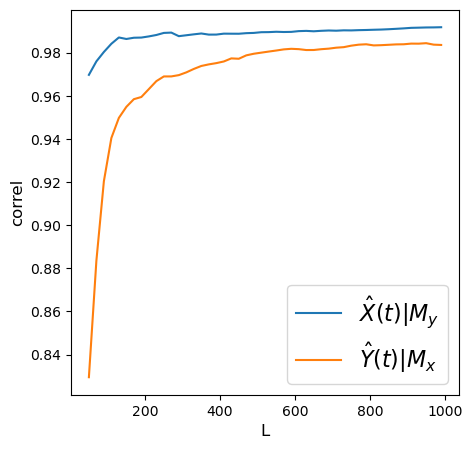

In [21]:
ccm.plot_convergence()

In [22]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5071,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.3677,
 'CriticalValue(0.05)': 0.3536,
 'CriticalValue(0.10)': 0.3461}

In [23]:
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.1043,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.2069,
 'CriticalValue(0.05)': 0.1972,
 'CriticalValue(0.10)': 0.192}

In [24]:
te.cte_xyz(y, x, x)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.3627,
 'CriticalValue(0.05)': 0.3503,
 'CriticalValue(0.10)': 0.3438}

# case 3

In [80]:
def func_3(x, y, z, sigma, rho, beta, noise):
    x_ = sigma * (-x + y) + 0.5*x*x + 0.01*noise[0]
    y_ = x * (rho - z) - y + y + 0.01*noise[1]
    z_ = 0.3*noise[2]
    return x_, y_, z_

In [81]:
# generate data
sigma, rho, beta = 0.8, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0]
y = [y0]
z = [z0]
for i in range(t):
    x_, y_, z_ = func_3(x[-1], y[-1], z[-1], sigma, rho, beta, noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 

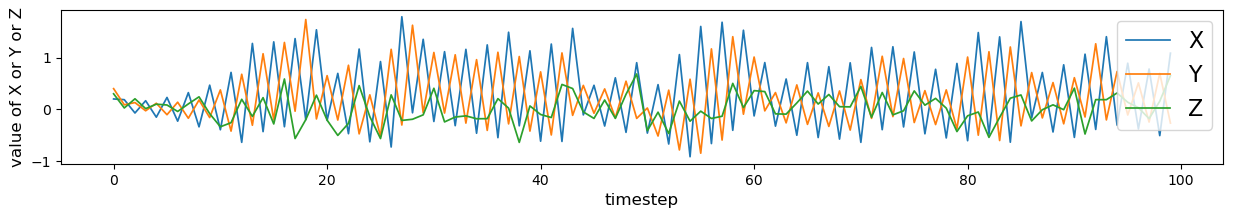

In [82]:
plt.figure(figsize=(15,2))
max_t = 100
plt.plot(x[:max_t], linewidth=1.25, label='X')
plt.plot(y[:max_t], linewidth=1.25, label='Y')
plt.plot(z[:max_t], linewidth=1.25, label='Z')
plt.xlabel('timestep', size=12)
plt.ylabel('value of X or Y or Z', size=12)
plt.legend(prop={'size': 16})

In [83]:
df = pd.DataFrame({"X":x,"Y":y,"Z":z})
stt = StationaryTest(df)
stt.adf_test()

Tips: p > 0.05 or Test statistic > Critical value, implies trend is stationary can be rejected


X       Y        Z
Test statistic       -7.9521 -6.9376 -32.5244
p-value               0.0000  0.0000   0.0000
Critical value - 1%  -3.4370 -3.4370  -3.4369
Critical value - 5%  -2.8645 -2.8645  -2.8644
Critical value - 10% -2.5683 -2.5683  -2.5683

In [84]:
stt.kpss_test()

Tips: p < 0.05 or Test statistic > Critical value, implies trend is stationary can be rejected


X       Y       Z
Test statistic         0.0241  0.0202  0.0446
p-value                0.1000  0.1000  0.1000
Critical value - 1%    0.2160  0.2160  0.2160
Critical value - 2.5%  0.1760  0.1760  0.1760
Critical value - 5%    0.1460  0.1460  0.1460
Critical value - 10%   0.1190  0.1190  0.1190

In [85]:
select_lag(df)

AIC     7
BIC     4
HQIC    7
FPE     7
dtype: int64


In [87]:
gct = GrangerCausality(df,4)
gct.granger_causation_matrix()

Tips: p<0.05, implies the x does not cause y can be rejected


X_x     Y_x  Z_x
X_y  1.0000  0.0000  0.0
Y_y  0.0000  1.0000  0.0
Z_y  0.0113  0.0173  1.0

In [88]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 2 # time lag
E = 2 # shadow manifold embedding dimensions
L = 1000 # length of time period to consider

ccm = ConvergentCrossMapping(x, y, tau, E, L)
ccm.plot_convergence()

Tips: p < 0.05, implies the x does not cause y can be rejected
X->Y r 0.91 p value 0.0
Y->X r 0.79 p value 0.0


In [89]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 2 # time lag
E = 2 # shadow manifold embedding dimensions
L = 1000 # length of time period to consider

ccm = ConvergentCrossMapping(x, z, tau, E, L)
ccm.plot_convergence()

Tips: p < 0.05, implies the x does not cause y can be rejected
X->Y r -0.01 p value 0.85
Y->X r 0.02 p value 0.51


In [90]:
np.random.seed(1) # we fix the seed when randomly choosing cross mapping points
tau = 2 # time lag
E = 2 # shadow manifold embedding dimensions
L = 1000 # length of time period to consider

ccm = ConvergentCrossMapping(y, z, tau, E, L)
ccm.plot_convergence()

Tips: p < 0.05, implies the x does not cause y can be rejected
X->Y r -0.03 p value 0.3
Y->X r 0.03 p value 0.31


In [91]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.6394,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.509,
 'CriticalValue(0.05)': 0.4915,
 'CriticalValue(0.10)': 0.4822}

In [92]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(y, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.7192,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.5094,
 'CriticalValue(0.05)': 0.4917,
 'CriticalValue(0.10)': 0.4823}

In [93]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 1.0826,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.5879,
 'CriticalValue(0.05)': 0.5692,
 'CriticalValue(0.10)': 0.5592}

In [94]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(x, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5032,
 'p_value': 0.7652,
 'CriticalValue(0.01)': 0.5883,
 'CriticalValue(0.05)': 0.5693,
 'CriticalValue(0.10)': 0.5592}

In [95]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(z, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8233,
 'p_value': 0.3347,
 'CriticalValue(0.01)': 0.8992,
 'CriticalValue(0.05)': 0.872,
 'CriticalValue(0.10)': 0.8575}

In [96]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(z, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.7309,
 'p_value': 0.9689,
 'CriticalValue(0.01)': 0.8968,
 'CriticalValue(0.05)': 0.8698,
 'CriticalValue(0.10)': 0.8554}

# case 7

In [400]:
def func_7(x, y, z, sigma, rho, beta, noise):
    x_ = y-z + 0.01*noise[0] #
    y_ = 0.5*noise[1]
    z_ = 0.5*noise[2]
    return x_, y_, z_
# generate data
sigma, rho, beta = 0.9, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0]
y = [y0]
z = [z0]
for i in range(t):
    x_, y_, z_ = func_7(x[-1], y[-1], z[-1], sigma, rho, beta, noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 
df = pd.DataFrame({"X":x,"Y":y,"Z":z})

In [282]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9361,
 'p_value': 0.2566,
 'CriticalValue(0.01)': 1.0072,
 'CriticalValue(0.05)': 0.9782,
 'CriticalValue(0.10)': 0.9628}

In [283]:
te.te_xy(y, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9076,
 'p_value': 0.498,
 'CriticalValue(0.01)': 1.0025,
 'CriticalValue(0.05)': 0.9746,
 'CriticalValue(0.10)': 0.9598}

In [284]:
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9947,
 'p_value': 0.0001,
 'CriticalValue(0.01)': 0.9333,
 'CriticalValue(0.05)': 0.9059,
 'CriticalValue(0.10)': 0.8912}

In [285]:
te.te_xy(x, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9784,
 'p_value': 0.0003,
 'CriticalValue(0.01)': 0.933,
 'CriticalValue(0.05)': 0.9048,
 'CriticalValue(0.10)': 0.8897}

In [286]:
te.te_xy(z, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8607,
 'p_value': 0.099,
 'CriticalValue(0.01)': 0.9029,
 'CriticalValue(0.05)': 0.8752,
 'CriticalValue(0.10)': 0.8604}

In [287]:
te.te_xy(z, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8244,
 'p_value': 0.3793,
 'CriticalValue(0.01)': 0.9043,
 'CriticalValue(0.05)': 0.8773,
 'CriticalValue(0.10)': 0.863}

In [288]:
te.cte_xyz(x, z, y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 1.272,
 'p_value': 0.0,
 'CriticalValue(0.01)': 1.1017,
 'CriticalValue(0.05)': 1.0836,
 'CriticalValue(0.10)': 1.0739}

In [289]:
te.te_xy(x, z+y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8197,
 'p_value': 0.6599,
 'CriticalValue(0.01)': 0.9345,
 'CriticalValue(0.05)': 0.9059,
 'CriticalValue(0.10)': 0.8907}

In [290]:
te.te_xy(x, z-y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 2.2327,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.933,
 'CriticalValue(0.05)': 0.905,
 'CriticalValue(0.10)': 0.8901}

In [291]:
te.te_xy(x, z*y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8735,
 'p_value': 0.1803,
 'CriticalValue(0.01)': 0.9322,
 'CriticalValue(0.05)': 0.9039,
 'CriticalValue(0.10)': 0.8887}

In [292]:
te.cte_xyz(x, z-y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 1.4042,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.9107,
 'CriticalValue(0.05)': 0.8891,
 'CriticalValue(0.10)': 0.8776}

In [293]:
te.cte_xyz(x, z*y, z-y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0451,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.1209,
 'CriticalValue(0.05)': 0.1167,
 'CriticalValue(0.10)': 0.1144}

## ARIMA

In [358]:
tmp=y-z
p = np.polyfit(tmp[:900], x[1:901], 1)
p

array([ 9.99875358e-01, -3.68678670e-04])

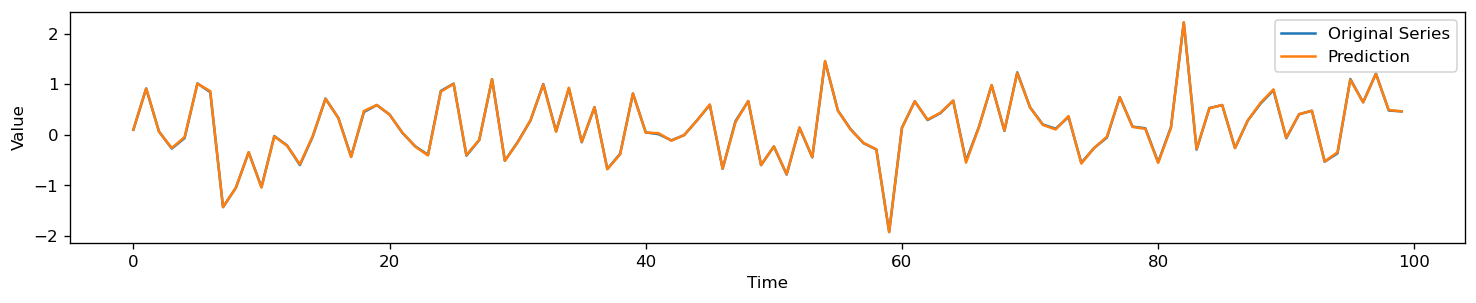

In [361]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(x[1:101],label='Original Series')
axes.plot(np.polyval(p, tmp[0:100]),label='Prediction')
axes.set_xlabel('Time')
axes.set_ylabel('Value')
plt.legend()

# case 8

In [397]:
def func_8(x, y, z, sigma, rho, beta, noise):
    x_ = y*z + 0.01*noise[0] #
    y_ = 0.5*noise[1]
    z_ = 0.5*noise[2]
    return x_, y_, z_
# generate data
sigma, rho, beta = 0.9, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0]
y = [y0]
z = [z0]
for i in range(t):
    x_, y_, z_ = func_8(x[-1], y[-1], z[-1], sigma, rho, beta, noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 
df = pd.DataFrame({"X":x,"Y":y,"Z":z})

In [223]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5296,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.9645,
 'CriticalValue(0.05)': 0.9368,
 'CriticalValue(0.10)': 0.922}

In [224]:
te.te_xy(y, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8506,
 'p_value': 0.6829,
 'CriticalValue(0.01)': 0.9667,
 'CriticalValue(0.05)': 0.9385,
 'CriticalValue(0.10)': 0.9234}

In [225]:
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5787,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.4118,
 'CriticalValue(0.05)': 0.3985,
 'CriticalValue(0.10)': 0.3913}

In [226]:
te.te_xy(x, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5544,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.412,
 'CriticalValue(0.05)': 0.3983,
 'CriticalValue(0.10)': 0.391}

In [227]:
te.te_xy(z, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.7871,
 'p_value': 0.5392,
 'CriticalValue(0.01)': 0.8815,
 'CriticalValue(0.05)': 0.8549,
 'CriticalValue(0.10)': 0.8408}

In [228]:
te.te_xy(z, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5036,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.88,
 'CriticalValue(0.05)': 0.8539,
 'CriticalValue(0.10)': 0.8399}

In [230]:
te.te_xy(x, z+y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.7099,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.4129,
 'CriticalValue(0.05)': 0.3991,
 'CriticalValue(0.10)': 0.3918}

In [231]:
te.te_xy(x, z-y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.6745,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.4112,
 'CriticalValue(0.05)': 0.3979,
 'CriticalValue(0.10)': 0.3908}

In [232]:
te.te_xy(x, z*y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 1.5142,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.4118,
 'CriticalValue(0.05)': 0.3983,
 'CriticalValue(0.10)': 0.3912}

In [233]:
te.cte_xyz(x, z-y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0597,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.0977,
 'CriticalValue(0.05)': 0.0937,
 'CriticalValue(0.10)': 0.0915}

In [234]:
te.cte_xyz(x, z*y, z-y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.8994,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.6004,
 'CriticalValue(0.05)': 0.5857,
 'CriticalValue(0.10)': 0.5779}

In [235]:
te.cte_xyz(x, z+y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0731,
 'p_value': 0.9583,
 'CriticalValue(0.01)': 0.0982,
 'CriticalValue(0.05)': 0.094,
 'CriticalValue(0.10)': 0.0918}

In [236]:
te.cte_xyz(x, z*y, z+y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.8774,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.5875,
 'CriticalValue(0.05)': 0.5724,
 'CriticalValue(0.10)': 0.5644}

# case 9

In [237]:
def func_9(x, y, z, sigma, rho, beta, noise):
    x_ = y+z + 0.01*noise[0] #
    y_ = 0.5*noise[1]
    z_ = 0.5*noise[2]
    return x_, y_, z_
# generate data
sigma, rho, beta = 0.9, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0]
y = [y0]
z = [z0]
for i in range(t):
    x_, y_, z_ = func_9(x[-1], y[-1], z[-1], sigma, rho, beta, noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 
df = pd.DataFrame({"X":x,"Y":y,"Z":z})

In [238]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8891,
 'p_value': 0.4569,
 'CriticalValue(0.01)': 0.9806,
 'CriticalValue(0.05)': 0.9525,
 'CriticalValue(0.10)': 0.9375}

In [239]:
te.te_xy(y, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9144,
 'p_value': 0.2198,
 'CriticalValue(0.01)': 0.9798,
 'CriticalValue(0.05)': 0.9511,
 'CriticalValue(0.10)': 0.9358}

In [240]:
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9973,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.9161,
 'CriticalValue(0.05)': 0.8879,
 'CriticalValue(0.10)': 0.8729}

In [241]:
te.te_xy(x, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9649,
 'p_value': 0.0001,
 'CriticalValue(0.01)': 0.9128,
 'CriticalValue(0.05)': 0.8857,
 'CriticalValue(0.10)': 0.8713}

In [242]:
te.te_xy(z, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8971,
 'p_value': 0.4197,
 'CriticalValue(0.01)': 0.9835,
 'CriticalValue(0.05)': 0.9558,
 'CriticalValue(0.10)': 0.941}

In [243]:
te.te_xy(z, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8773,
 'p_value': 0.604,
 'CriticalValue(0.01)': 0.9858,
 'CriticalValue(0.05)': 0.9573,
 'CriticalValue(0.10)': 0.942}

In [244]:
te.te_xy(x, z+y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 2.2756,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.9081,
 'CriticalValue(0.05)': 0.8811,
 'CriticalValue(0.10)': 0.8666}

In [245]:
te.te_xy(x, z-y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8572,
 'p_value': 0.1678,
 'CriticalValue(0.01)': 0.9104,
 'CriticalValue(0.05)': 0.8838,
 'CriticalValue(0.10)': 0.8696}

In [246]:
te.te_xy(x, z*y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8564,
 'p_value': 0.1819,
 'CriticalValue(0.01)': 0.9155,
 'CriticalValue(0.05)': 0.8871,
 'CriticalValue(0.10)': 0.8719}

In [247]:
te.cte_xyz(x, z-y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.803,
 'p_value': 0.9857,
 'CriticalValue(0.01)': 0.9455,
 'CriticalValue(0.05)': 0.924,
 'CriticalValue(0.10)': 0.9125}

In [248]:
te.cte_xyz(x, z*y, z-y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.8022,
 'p_value': 1.0,
 'CriticalValue(0.01)': 1.2218,
 'CriticalValue(0.05)': 1.2042,
 'CriticalValue(0.10)': 1.1948}

In [249]:
te.cte_xyz(x, z+y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 1.4572,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.9444,
 'CriticalValue(0.05)': 0.9233,
 'CriticalValue(0.10)': 0.9121}

In [250]:
te.cte_xyz(x, z*y, z+y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0379,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.0806,
 'CriticalValue(0.05)': 0.0776,
 'CriticalValue(0.10)': 0.0759}

# case 10

In [267]:
def func_10(x, y, z, sigma, rho, beta, noise):
    x_ = y+z + y*z + 0.01*noise[0] #
    y_ = 0.5*noise[1]
    z_ = 0.5*noise[2]
    return x_, y_, z_
# generate data
sigma, rho, beta = 0.9, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0]
y = [y0]
z = [z0]
for i in range(t):
    x_, y_, z_ = func_10(x[-1], y[-1], z[-1], sigma, rho, beta, noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 
df = pd.DataFrame({"X":x,"Y":y,"Z":z})

In [268]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.6737,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.9379,
 'CriticalValue(0.05)': 0.9104,
 'CriticalValue(0.10)': 0.8957}

In [269]:
te.te_xy(y, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8644,
 'p_value': 0.3126,
 'CriticalValue(0.01)': 0.9433,
 'CriticalValue(0.05)': 0.914,
 'CriticalValue(0.10)': 0.8984}

In [270]:
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.7825,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.6295,
 'CriticalValue(0.05)': 0.6087,
 'CriticalValue(0.10)': 0.5976}

In [271]:
te.te_xy(x, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8227,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.6276,
 'CriticalValue(0.05)': 0.607,
 'CriticalValue(0.10)': 0.596}

In [272]:
te.te_xy(z, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8813,
 'p_value': 0.4683,
 'CriticalValue(0.01)': 0.9753,
 'CriticalValue(0.05)': 0.9468,
 'CriticalValue(0.10)': 0.9316}

In [273]:
te.te_xy(z, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.6924,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.9711,
 'CriticalValue(0.05)': 0.9436,
 'CriticalValue(0.10)': 0.9289}

In [274]:
te.te_xy(x, z+y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 1.4668,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.6297,
 'CriticalValue(0.05)': 0.6084,
 'CriticalValue(0.10)': 0.5971}

In [275]:
te.te_xy(x, z-y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5741,
 'p_value': 0.3125,
 'CriticalValue(0.01)': 0.6345,
 'CriticalValue(0.05)': 0.6121,
 'CriticalValue(0.10)': 0.6001}

In [276]:
te.te_xy(x, z*y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.6964,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.6277,
 'CriticalValue(0.05)': 0.6069,
 'CriticalValue(0.10)': 0.5958}

In [277]:
te.cte_xyz(x, z-y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.6593,
 'p_value': 0.7779,
 'CriticalValue(0.01)': 0.7467,
 'CriticalValue(0.05)': 0.7274,
 'CriticalValue(0.10)': 0.7172}

In [278]:
te.cte_xyz(x, z*y, z-y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.7816,
 'p_value': 1.0,
 'CriticalValue(0.01)': 1.1454,
 'CriticalValue(0.05)': 1.125,
 'CriticalValue(0.10)': 1.1141}

In [279]:
te.cte_xyz(x, z+y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 1.1354,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.7484,
 'CriticalValue(0.05)': 0.7294,
 'CriticalValue(0.10)': 0.7194}

In [280]:
te.cte_xyz(x, z*y, z+y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.3649,
 'p_value': 0.9948,
 'CriticalValue(0.01)': 0.4484,
 'CriticalValue(0.05)': 0.4367,
 'CriticalValue(0.10)': 0.4305}

# case 11

In [364]:
def func_11(x, y, z, sigma, rho, beta, noise):
    x_ = (y-z)*(y-z) + 0.01*noise[0] #
    y_ = 0.5*noise[1]
    z_ = 0.5*noise[2]
    return x_, y_, z_
# generate data
sigma, rho, beta = 0.9, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0]
y = [y0]
z = [z0]
for i in range(t):
    x_, y_, z_ = func_11(x[-1], y[-1], z[-1], sigma, rho, beta, noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 
df = pd.DataFrame({"X":x,"Y":y,"Z":z})

In [365]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy(y, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.4185,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.8947,
 'CriticalValue(0.05)': 0.8668,
 'CriticalValue(0.10)': 0.852}

In [366]:
te.te_xy(y, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.8697,
 'p_value': 0.0507,
 'CriticalValue(0.01)': 0.8984,
 'CriticalValue(0.05)': 0.87,
 'CriticalValue(0.10)': 0.8548}

In [367]:
te.te_xy(x, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.3548,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.309,
 'CriticalValue(0.05)': 0.2982,
 'CriticalValue(0.10)': 0.2925}

In [368]:
te.te_xy(x, z)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.3939,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.3082,
 'CriticalValue(0.05)': 0.2974,
 'CriticalValue(0.10)': 0.2916}

In [369]:
te.te_xy(z, y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.9734,
 'p_value': 0.4357,
 'CriticalValue(0.01)': 1.0625,
 'CriticalValue(0.05)': 1.0345,
 'CriticalValue(0.10)': 1.0195}

In [370]:
te.te_xy(z, x)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.5048,
 'p_value': 1.0,
 'CriticalValue(0.01)': 1.0639,
 'CriticalValue(0.05)': 1.0342,
 'CriticalValue(0.10)': 1.0183}

In [372]:
te.te_xy(x, z+y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.2645,
 'p_value': 0.6693,
 'CriticalValue(0.01)': 0.3093,
 'CriticalValue(0.05)': 0.2983,
 'CriticalValue(0.10)': 0.2924}

In [373]:
te.te_xy(x, z-y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 1.115,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.309,
 'CriticalValue(0.05)': 0.298,
 'CriticalValue(0.10)': 0.2921}

In [374]:
te.te_xy(x, z*y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.6424,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.3104,
 'CriticalValue(0.05)': 0.2991,
 'CriticalValue(0.10)': 0.2931}

In [375]:
te.cte_xyz(x, z-y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.5668,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.3434,
 'CriticalValue(0.05)': 0.3332,
 'CriticalValue(0.10)': 0.3278}

In [376]:
te.cte_xyz(x, z*y, z-y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0941,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.1692,
 'CriticalValue(0.05)': 0.1628,
 'CriticalValue(0.10)': 0.1595}

## ARIMA

In [383]:
tmp=z-y
p = np.polyfit(tmp[:900], x[1:901], 6)
p

array([-1.23104984e-05,  3.63149630e-05, -6.16639201e-04, -1.95400352e-04,
        1.00159935e+00,  1.84243260e-04, -9.69861505e-05])

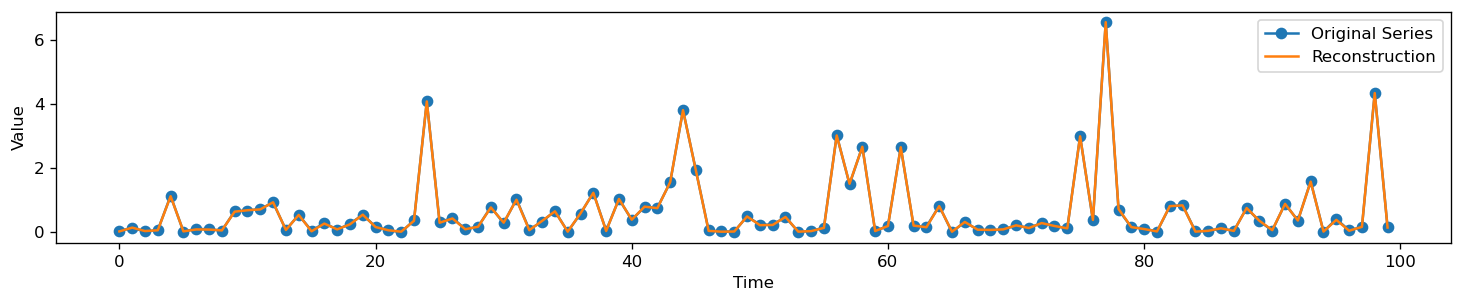

In [386]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(x[1:101], "-o", label='Original Series')
axes.plot(np.polyval(p, tmp[0:100]),label='Reconstruction')
axes.set_xlabel('Time')
axes.set_ylabel('Value')
plt.legend()
plt.savefig("Reconstruction State Space", bbox_inches="tight")

# case 12

In [65]:
def func_12(x, y, z, noise):
    x_ = (y-z)*(y-z) + 0.01*noise[0] #
    y_ = 0.5*noise[1]
    z_ = 0.5*noise[2]
    return x_, y_, z_
# generate data
sigma, rho, beta = 0.9, 0.7, 4/3

x0 = 0.2
y0 = 0.4
z0 = 0.3

x1 = 0.4
y1 = 0.5
z1 = 0.6

t = 1000 # time steps
noise = stats.norm.rvs(size=(1000,3))

x = [x0, x1]
y = [y0, y1]
z = [z0, z1]
for i in range(t):
    x_, y_, z_ = func_12(x[-1], y[-1], z[-2], noise[i])  
    x.append(x_)
    y.append(y_) 
    z.append(z_) 
df = pd.DataFrame({"Sampling Stamp":range(1,len(x)+1),"X":x,"Y":y,"Z":z})

In [66]:
plt.figure(figsize=(15,2))
max_t = 1000
plt.subplot(3, 1, 1)
plt.plot(x[:max_t], linewidth=1.25, label='X')
plt.subplot(3, 1, 2)
plt.plot(y[:max_t], linewidth=1.25, label='Y')
plt.subplot(3, 1, 3)
plt.plot(z[:max_t], linewidth=1.25, label='Z')
plt.xlabel('timestep', size=12)
plt.ylabel('value of X or Y or Z', size=12)
plt.legend(prop={'size': 16})

In [67]:
df.to_csv("case1.csv", index=False)

In [68]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values

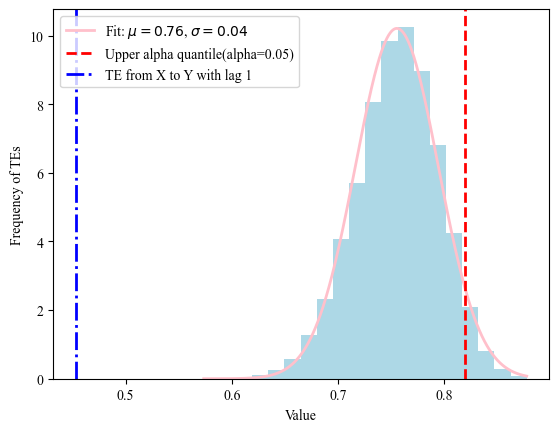

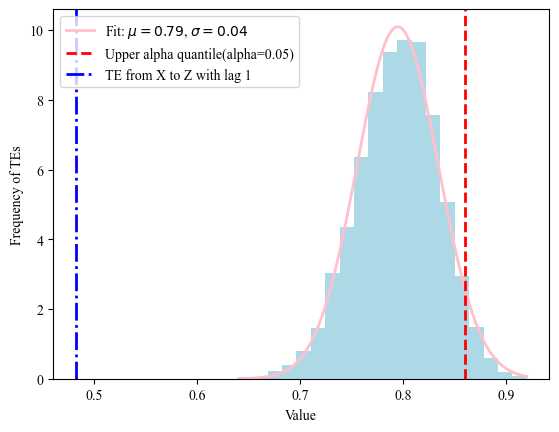

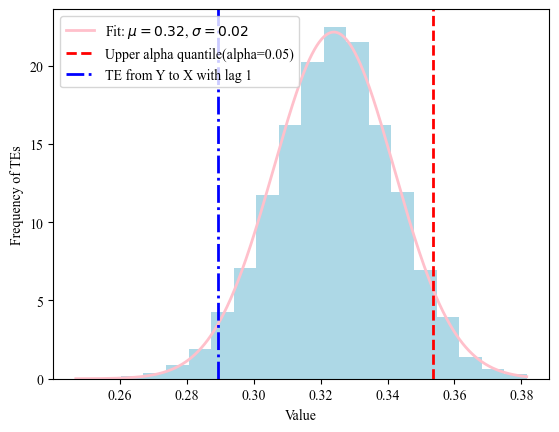

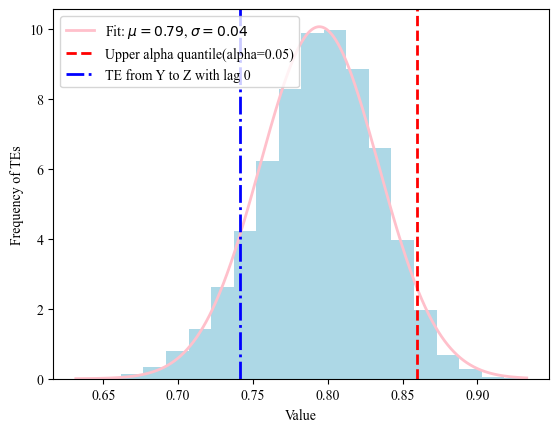

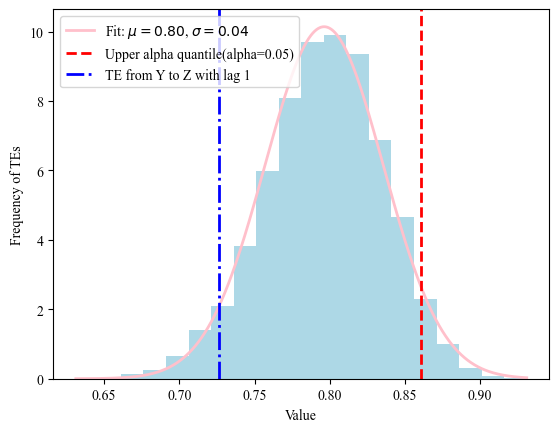

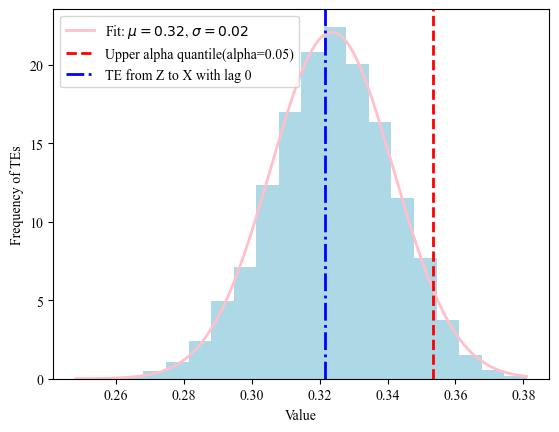

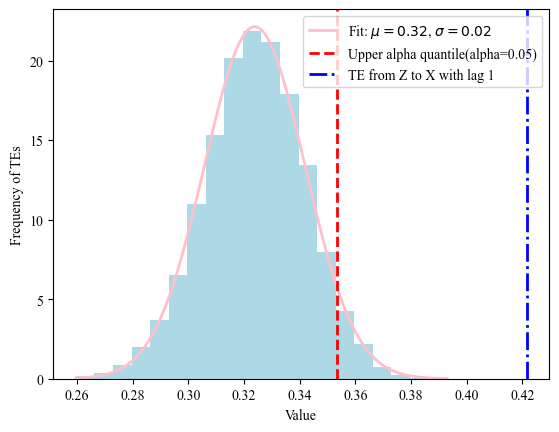

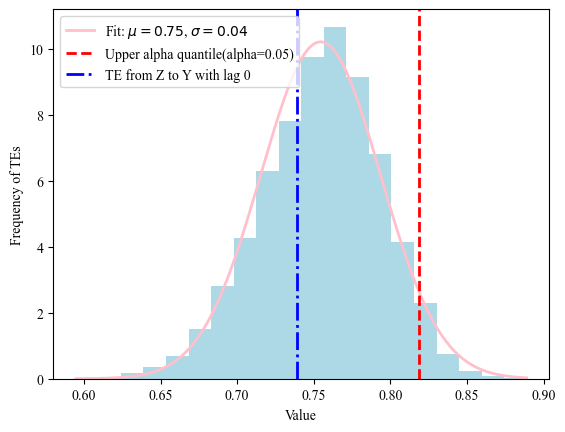

In [87]:
for Cause_name, Reason_name in [("x","y"), ("x","z"), ("y","x"), ("y","z"), ("z","x"),  ("z","y")]:  # 
    for lag in range(2):
#         Cause_name = "z"
#         Reason_name = "x"
#         lag = 1

        Cause = eval(Cause_name)
        Reason = eval(Reason_name)
        
        from scipy.stats import norm

        noise_mean = np.mean(Cause)
        noise_std_dev = np.std(Cause)
        TEs = []
        for i in range(10000):    
#             wgn = np.random.normal(noise_mean, noise_std_dev, len(Cause))# 生成高斯白噪声
            wgn = stats.norm.rvs(size=np.array(Cause).shape)
            TEs.append(te.te_xy_with_lag_sigma(Reason, wgn, lag_x=lag))
        TEs = np.array(TEs)
        # Calculate alpha percentile values
        mean = np.array(TEs).mean()
        std = np.array(TEs).std()
        alpha_percentile = 0.05
        alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

        TExy = te.te_xy_with_lag(Reason, Cause, lag_x=lag)["TE(X->Y)"]

        # 生成拟合曲线数据
        x_ = np.linspace(min(TEs), max(TEs), 1000)
        y_ = norm.pdf(x_, mean, std)

        # 绘制拟合曲线
        plt.figure()
        plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

        # Create a histogram
        plt.hist(TEs, bins=20, density=True, color="lightblue")  # , edgecolor='black'
        plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2, label=f'Upper alpha quantile(alpha={alpha_percentile})')
        plt.axvline(TExy, color='blue', linestyle='-.', linewidth=2, label=f'TE from {str(Cause_name).upper()} to {str(Reason_name).upper()} with lag {lag}')
#         plt.title('Histogram of TEs')
        plt.xlabel('Value')
        plt.ylabel('Frequency of TEs')
        plt.legend()

        # Save the plot
        plt.savefig(f'TE{str(Cause_name)}{str(Reason_name)}_lag{str(lag)}.png', dpi=600, bbox_inches='tight')

In [4]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
z = df.Z.values
te.te_xy_with_lag(y, x, lag_x=0), te.te_xy_with_lag(y, x, lag_x=1)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


({'TE(X->Y)': 0.3789,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.8408,
  'CriticalValue(0.05)': 0.8147,
  'CriticalValue(0.10)': 0.8007},
 {'TE(X->Y)': 0.3777,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.8429,
  'CriticalValue(0.05)': 0.8163,
  'CriticalValue(0.10)': 0.8021})

In [ ]:
Cause = eval(Cause_name)
Reason = eval(Reason_name)

from scipy.stats import norm

noise_mean = np.mean(Cause)
noise_std_dev = np.std(Cause)
TEs = []
for i in range(10000):    
#             wgn = np.random.normal(noise_mean, noise_std_dev, len(Cause))# 生成高斯白噪声
    wgn = stats.norm.rvs(size=np.array(Cause).shape)
    TEs.append(te.te_xy_with_lag_sigma(Reason, wgn, lag_x=lag))
TEs = np.array(TEs)
# Calculate alpha percentile values
mean = np.array(TEs).mean()
std = np.array(TEs).std()
alpha_percentile = 0.05
alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

TExy = te.te_xy_with_lag(Reason, Cause, lag_x=lag)["TE(X->Y)"]

# 生成拟合曲线数据
x_ = np.linspace(min(TEs), max(TEs), 1000)
y_ = norm.pdf(x_, mean, std)

# 绘制拟合曲线
plt.figure()
plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

# Create a histogram
plt.hist(TEs, bins=20, density=True, color="lightblue")  # , edgecolor='black'
plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2, label=f'Upper alpha quantile(alpha={alpha_percentile})')
plt.axvline(TExy, color='blue', linestyle='-.', linewidth=2, label=f'TE from {str(Cause_name).upper()} to {str(Reason_name).upper()} with lag {lag}')
#         plt.title('Histogram of TEs')
plt.xlabel('Value')
plt.ylabel('Frequency of TEs')
plt.legend()

# Save the plot
plt.savefig(f'TE{str(Cause_name)}{str(Reason_name)}_lag{str(lag)}.png', dpi=600, bbox_inches='tight')

In [5]:
te.te_xy_with_lag(y, z, lag_x=0), te.te_xy_with_lag(y, z, lag_x=1)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


({'TE(X->Y)': 0.6799,
  'p_value': 0.9639,
  'CriticalValue(0.01)': 0.8444,
  'CriticalValue(0.05)': 0.8172,
  'CriticalValue(0.10)': 0.8027},
 {'TE(X->Y)': 0.6858,
  'p_value': 0.963,
  'CriticalValue(0.01)': 0.8437,
  'CriticalValue(0.05)': 0.8175,
  'CriticalValue(0.10)': 0.8036})

In [6]:
te.te_xy_with_lag(x, y, lag_x=0), te.te_xy_with_lag(x, y, lag_x=1)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


({'TE(X->Y)': 0.3429,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2891,
  'CriticalValue(0.05)': 0.2786,
  'CriticalValue(0.10)': 0.273},
 {'TE(X->Y)': 0.2385,
  'p_value': 0.8401,
  'CriticalValue(0.01)': 0.2897,
  'CriticalValue(0.05)': 0.2792,
  'CriticalValue(0.10)': 0.2736})

In [7]:
te.te_xy_with_lag(x, z, lag_x=0), te.te_xy_with_lag(x, z, lag_x=1)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


({'TE(X->Y)': 0.2455,
  'p_value': 0.6802,
  'CriticalValue(0.01)': 0.2883,
  'CriticalValue(0.05)': 0.2779,
  'CriticalValue(0.10)': 0.2723},
 {'TE(X->Y)': 0.3456,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2883,
  'CriticalValue(0.05)': 0.2783,
  'CriticalValue(0.10)': 0.2729})

In [9]:
te.te_xy_with_lag(z, y, lag_x=0), te.te_xy_with_lag(z, y, lag_x=1)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


({'TE(X->Y)': 0.6823,
  'p_value': 0.8736,
  'CriticalValue(0.01)': 0.814,
  'CriticalValue(0.05)': 0.7881,
  'CriticalValue(0.10)': 0.7744},
 {'TE(X->Y)': 0.688,
  'p_value': 0.8406,
  'CriticalValue(0.01)': 0.8178,
  'CriticalValue(0.05)': 0.7912,
  'CriticalValue(0.10)': 0.777})

In [10]:
te.te_xy_with_lag(z, x, lag_x=0), te.te_xy_with_lag(z, x, lag_x=1)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


({'TE(X->Y)': 0.3478,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.8114,
  'CriticalValue(0.05)': 0.7866,
  'CriticalValue(0.10)': 0.7733},
 {'TE(X->Y)': 0.347,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.8209,
  'CriticalValue(0.05)': 0.7938,
  'CriticalValue(0.10)': 0.7793})

In [11]:
x = df.X.values[1:]
y = df.Y.values[1:]
z = df.Z.values[:-1]
te.te_xy_with_lag(x, z+y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.2552,
 'p_value': 0.444,
 'CriticalValue(0.01)': 0.2896,
 'CriticalValue(0.05)': 0.2789,
 'CriticalValue(0.10)': 0.2732}

In [12]:
x = df.X.values[1:]
y = df.Y.values[1:]
z = df.Z.values[:-1]
te.te_xy_with_lag(x, z-y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 1.1122,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.2895,
 'CriticalValue(0.05)': 0.279,
 'CriticalValue(0.10)': 0.2734}

In [13]:
x = df.X.values[1:]
y = df.Y.values[1:]
z = df.Z.values[:-1]
te.te_xy_with_lag(x, z*y)

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test


{'TE(X->Y)': 0.6394,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.2895,
 'CriticalValue(0.05)': 0.2789,
 'CriticalValue(0.10)': 0.2732}

In [14]:
x = df.X.values[1:]
y = df.Y.values[1:]
z = df.Z.values[:-1]
te.cte_xyz(x, z-y, z*y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.5617,
 'p_value': 0.0,
 'CriticalValue(0.01)': 0.3099,
 'CriticalValue(0.05)': 0.3006,
 'CriticalValue(0.10)': 0.2957}

In [15]:
x = df.X.values[1:]
y = df.Y.values[1:]
z = df.Z.values[:-1]
te.cte_xyz(x, z*y, z-y)

Tips: p < 0.05 or CTE > Critical value, implies the X does not cause Y given Z can be rejected according to Z-test


{'CTE(X->Y|Z)': 0.0889,
 'p_value': 1.0,
 'CriticalValue(0.01)': 0.1459,
 'CriticalValue(0.05)': 0.1406,
 'CriticalValue(0.10)': 0.1377}

## ARIMA

In [16]:
x = df.X.values[1:]
y = df.Y.values[1:]
z = df.Z.values[:-1]
tmp=z-y
p = np.polyfit(tmp[:900], x[1:901], 6)
p

array([-3.16089346e-04,  2.53234366e-04,  1.98432296e-03,  7.13975534e-05,
        9.96554306e-01, -2.51131428e-04,  8.60479291e-04])

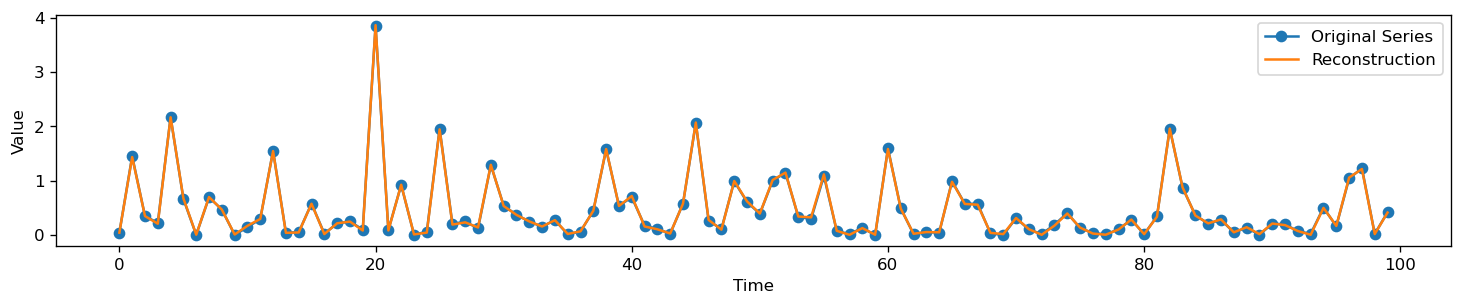

In [17]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(x[1:101], "-o", label='Original Series')
axes.plot(np.polyval(p, tmp[0:100]),label='Reconstruction')
axes.set_xlabel('Time')
axes.set_ylabel('Value')
plt.legend()
plt.savefig("Reconstruction State Space", bbox_inches="tight")

# HenonMap

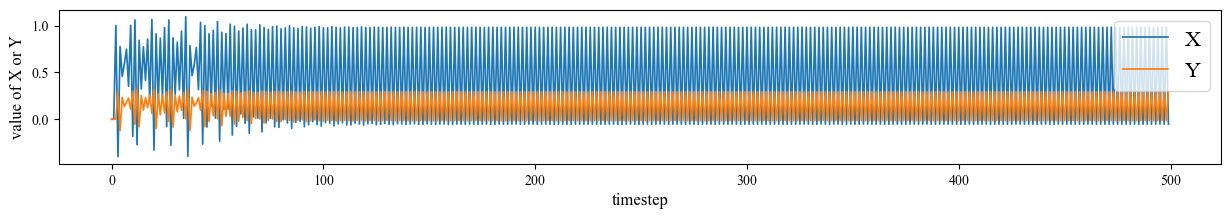

In [161]:
noise = stats.norm.rvs(size=(2000,3))
def HenonMap(x, y, noise, alpha=1.4, beta=0.3):
    x_ = 1 - alpha * x * x + y + 0.0001*noise[0]
    y_ = beta * x + 0.0001*noise[1]
    return x_, y_
x0 = 0.0  # initial val
y0 = 0.0  # initial val
t = 2000  # time steps

x = [x0, x0]
y = [y0, y0]
for i in range(t):
    x_, y_  = HenonMap(x[-1], y[-2], noise[i])
    x.append(x_)
    y.append(y_)
df = pd.DataFrame({"X": x, "Y": y})
plt.figure(figsize=(15,2))
max_t = 500
plt.plot(x[:max_t], linewidth=1.25, label='X')
plt.plot(y[:max_t], linewidth=1.25, label='Y')
plt.xlabel('timestep', size=12)
plt.ylabel('value of X or Y', size=12)
plt.legend(prop={'size': 16})

In [163]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values

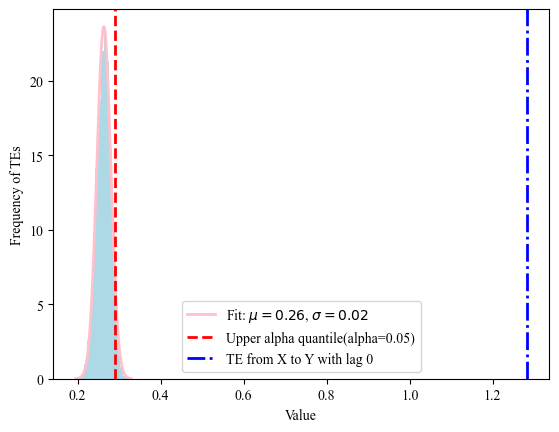

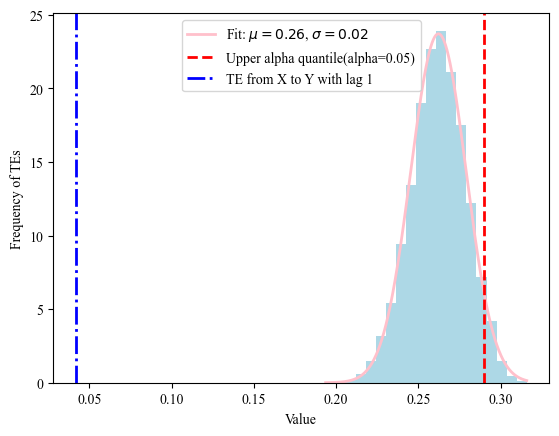

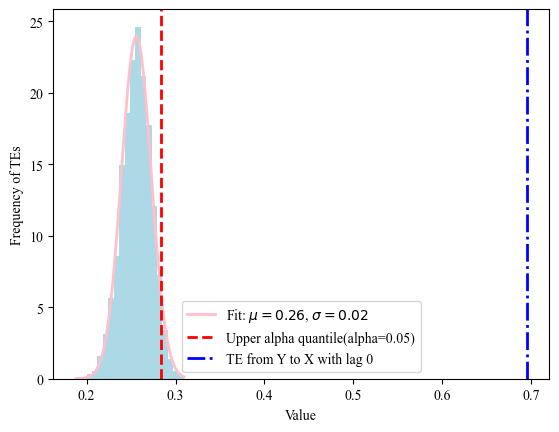

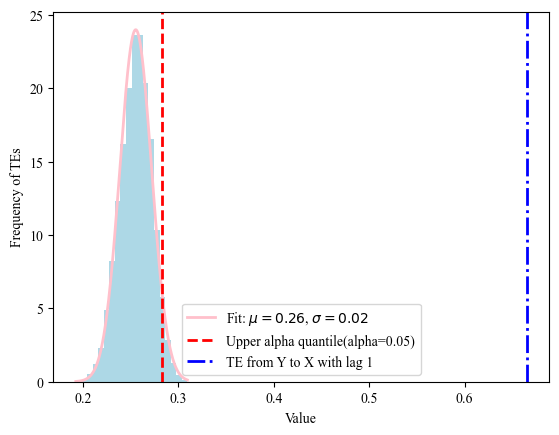

In [123]:
te = TransferEntropy()
x = df.X.values
y = df.Y.values
for Cause_name, Reason_name in [("x","y"), ("y","x")]:  # 
    for lag in range(2):
#         Cause_name = "z"
#         Reason_name = "x"
#         lag = 1

        Cause = eval(Cause_name)
        Reason = eval(Reason_name)
        
        from scipy.stats import norm

        noise_mean = np.mean(Cause)
        noise_std_dev = np.std(Cause)
        TEs = []
        for i in range(10000):    
#             wgn = np.random.normal(noise_mean, noise_std_dev, len(Cause))# 生成高斯白噪声
            wgn = stats.norm.rvs(size=np.array(Cause).shape)
            TEs.append(te.te_xy_with_lag_sigma(Reason, wgn, lag_x=lag))
        TEs = np.array(TEs)
        # Calculate alpha percentile values
        mean = np.array(TEs).mean()
        std = np.array(TEs).std()
        alpha_percentile = 0.05
        alpha_value = round(stats.norm.isf(alpha_percentile)*std+mean, 4)

        TExy = te.te_xy_with_lag(Reason, Cause, lag_x=lag)["TE(X->Y)"]

        # 生成拟合曲线数据
        x_ = np.linspace(min(TEs), max(TEs), 1000)
        y_ = norm.pdf(x_, mean, std)

        # 绘制拟合曲线
        plt.figure()
        plt.plot(x_, y_, 'pink', linewidth=2, label='Fit: $\mu=%.2f$, $\sigma=%.2f$' % (mean, std))

        # Create a histogram
        plt.hist(TEs, bins=20, density=True, color="lightblue")  # , edgecolor='black'
        plt.axvline(alpha_value, color='red', linestyle='dashed', linewidth=2, label=f'Upper alpha quantile(alpha={alpha_percentile})')
        plt.axvline(TExy, color='blue', linestyle='-.', linewidth=2, label=f'TE from {str(Cause_name).upper()} to {str(Reason_name).upper()} with lag {lag}')
#         plt.title('Histogram of TEs')
        plt.xlabel('Value')
        plt.ylabel('Frequency of TEs')
        plt.legend()

        # Save the plot
        plt.savefig(f'TE{str(Cause_name)}{str(Reason_name)}_lag{str(lag)}.png', dpi=600, bbox_inches='tight')

In [124]:
te.te_xy_with_lag(x, y), te.te_xy_with_lag(y,x)

({'TE(X->Y)': 0.6952,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2956,
  'CriticalValue(0.05)': 0.284,
  'CriticalValue(0.10)': 0.2778},
 {'TE(X->Y)': 1.2823,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.3036,
  'CriticalValue(0.05)': 0.292,
  'CriticalValue(0.10)': 0.2857})

In [125]:
te.te_xy_with_lag(x, y+x), te.te_xy_with_lag(x, y-x)

({'TE(X->Y)': 0.6383,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2954,
  'CriticalValue(0.05)': 0.284,
  'CriticalValue(0.10)': 0.278},
 {'TE(X->Y)': 0.7189,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2946,
  'CriticalValue(0.05)': 0.2835,
  'CriticalValue(0.10)': 0.2775})

In [126]:
te.te_xy_with_lag(y, y+x), te.te_xy_with_lag(y, y-x)

({'TE(X->Y)': 0.9871,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.3013,
  'CriticalValue(0.05)': 0.2901,
  'CriticalValue(0.10)': 0.2842},
 {'TE(X->Y)': 0.8899,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.3015,
  'CriticalValue(0.05)': 0.2902,
  'CriticalValue(0.10)': 0.2841})

In [127]:
te.cte_xyz(y, y+x, x), te.cte_xyz(y, y-x, x)

({'CTE(X->Y|Z)': 0.0245,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0534,
  'CriticalValue(0.05)': 0.0514,
  'CriticalValue(0.10)': 0.0503},
 {'CTE(X->Y|Z)': 0.0099,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0532,
  'CriticalValue(0.05)': 0.0512,
  'CriticalValue(0.10)': 0.0501})

In [128]:
te.cte_xyz(x, y+x, y), te.cte_xyz(x, y-x, y)

({'CTE(X->Y|Z)': 0.1507,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2686,
  'CriticalValue(0.05)': 0.2596,
  'CriticalValue(0.10)': 0.2548},
 {'CTE(X->Y|Z)': 0.1608,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2716,
  'CriticalValue(0.05)': 0.2618,
  'CriticalValue(0.10)': 0.2566})

In [129]:
te.cte_xyz(x, y*y+x, y), te.cte_xyz(x, y*y-x, y), te.cte_xyz(x, y+x*y, y), te.cte_xyz(x, y-x*y, y)

({'CTE(X->Y|Z)': 0.0712,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2707,
  'CriticalValue(0.05)': 0.2614,
  'CriticalValue(0.10)': 0.2565},
 {'CTE(X->Y|Z)': 0.0536,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2693,
  'CriticalValue(0.05)': 0.2601,
  'CriticalValue(0.10)': 0.2552},
 {'CTE(X->Y|Z)': 0.1824,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2695,
  'CriticalValue(0.05)': 0.2603,
  'CriticalValue(0.10)': 0.2554},
 {'CTE(X->Y|Z)': 0.0598,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2695,
  'CriticalValue(0.05)': 0.2603,
  'CriticalValue(0.10)': 0.2554})

In [130]:
te.cte_xyz(x, y+x*x, y), te.cte_xyz(x, y-x*x, y)

({'CTE(X->Y|Z)': 0.2857,
  'p_value': 0.0001,
  'CriticalValue(0.01)': 0.2686,
  'CriticalValue(0.05)': 0.2595,
  'CriticalValue(0.10)': 0.2547},
 {'CTE(X->Y|Z)': 0.4132,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2705,
  'CriticalValue(0.05)': 0.2609,
  'CriticalValue(0.10)': 0.2557})

In [131]:
te.cte_xyz(y, y*y+x, x), te.cte_xyz(y, y*y-x, x), te.cte_xyz(y, y+x*y, x), te.cte_xyz(y, y-x*y, x)

({'CTE(X->Y|Z)': 0.0245,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0536,
  'CriticalValue(0.05)': 0.0515,
  'CriticalValue(0.10)': 0.0504},
 {'CTE(X->Y|Z)': 0.0163,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0535,
  'CriticalValue(0.05)': 0.0514,
  'CriticalValue(0.10)': 0.0502},
 {'CTE(X->Y|Z)': 0.0222,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0533,
  'CriticalValue(0.05)': 0.0512,
  'CriticalValue(0.10)': 0.0501},
 {'CTE(X->Y|Z)': 0.0096,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0532,
  'CriticalValue(0.05)': 0.0512,
  'CriticalValue(0.10)': 0.0501})

In [132]:
te.cte_xyz(y, y+x*x, x), te.cte_xyz(y, y-x*x, x)

({'CTE(X->Y|Z)': 0.0256,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0535,
  'CriticalValue(0.05)': 0.0514,
  'CriticalValue(0.10)': 0.0503},
 {'CTE(X->Y|Z)': 0.0246,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0533,
  'CriticalValue(0.05)': 0.0513,
  'CriticalValue(0.10)': 0.0502})

In [133]:
te.cte_xyz(x, -y+x*x, y), te.cte_xyz(x, -y-x*x, y)

({'CTE(X->Y|Z)': 0.4132,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2697,
  'CriticalValue(0.05)': 0.2604,
  'CriticalValue(0.10)': 0.2554},
 {'CTE(X->Y|Z)': 0.2857,
  'p_value': 0.0002,
  'CriticalValue(0.01)': 0.2692,
  'CriticalValue(0.05)': 0.2602,
  'CriticalValue(0.10)': 0.2554})

In [134]:
te.te_xy_with_lag(x, -y+x*x), te.te_xy_with_lag(x, -y-x*x)

({'TE(X->Y)': 1.0496,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2945,
  'CriticalValue(0.05)': 0.2831,
  'CriticalValue(0.10)': 0.2771},
 {'TE(X->Y)': 0.7432,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2941,
  'CriticalValue(0.05)': 0.2829,
  'CriticalValue(0.10)': 0.277})

In [135]:
te.te_xy_with_lag(x, y, lag_x=1), te.te_xy_with_lag(y, x, lag_x=1)

({'TE(X->Y)': 0.6652,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.292,
  'CriticalValue(0.05)': 0.2812,
  'CriticalValue(0.10)': 0.2754},
 {'TE(X->Y)': 0.0418,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.3015,
  'CriticalValue(0.05)': 0.2899,
  'CriticalValue(0.10)': 0.2838})

In [147]:
te.cte_xyz(x[1:], y[:-1], y[1:]), te.te_xy_with_lag(x, y), te.te_xy_with_lag(x[1:], y[:-1])

({'CTE(X->Y|Z)': 0.1315,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2701,
  'CriticalValue(0.05)': 0.2607,
  'CriticalValue(0.10)': 0.2557},
 {'TE(X->Y)': 0.6952,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.294,
  'CriticalValue(0.05)': 0.2825,
  'CriticalValue(0.10)': 0.2764},
 {'TE(X->Y)': 0.6652,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2948,
  'CriticalValue(0.05)': 0.283,
  'CriticalValue(0.10)': 0.2767})

In [164]:
for lag in range(5):
    print(te.te_xy_with_lag(x, y, lag_x=lag)["p_value"], te.te_xy_with_lag(y, x, lag_x=lag)["p_value"])

0.7977 0.0
0.0 1.0
0.0 0.7709
0.0 0.0
0.0 0.0


In [167]:
for lag in range(1,5):
    print(te.cte_xyz(x[lag+1:], y[:-lag-1], y[lag:-1])["p_value"], te.cte_xyz(y[lag:], x[:-lag], x[lag:])["p_value"])

0.0004 0.1657
0.9982 0.0933
0.0 0.4941
0.9971 0.0


In [138]:
te.cte_xyz(x, x*x, y), te.cte_xyz(x, x*y, y), te.cte_xyz(x, y*y, y)

({'CTE(X->Y|Z)': 0.3725,
  'p_value': 0.0,
  'CriticalValue(0.01)': 0.2693,
  'CriticalValue(0.05)': 0.2601,
  'CriticalValue(0.10)': 0.2552},
 {'CTE(X->Y|Z)': 0.1254,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2691,
  'CriticalValue(0.05)': 0.2598,
  'CriticalValue(0.10)': 0.2548},
 {'CTE(X->Y|Z)': 0.1442,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.2681,
  'CriticalValue(0.05)': 0.2591,
  'CriticalValue(0.10)': 0.2543})

In [139]:
te.cte_xyz(y, x*x, x), te.cte_xyz(y, x*y, x), te.cte_xyz(y, y*y, x)

({'CTE(X->Y|Z)': 0.0288,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0534,
  'CriticalValue(0.05)': 0.0513,
  'CriticalValue(0.10)': 0.0502},
 {'CTE(X->Y|Z)': 0.012,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0534,
  'CriticalValue(0.05)': 0.0513,
  'CriticalValue(0.10)': 0.0502},
 {'CTE(X->Y|Z)': 0.0179,
  'p_value': 1.0,
  'CriticalValue(0.01)': 0.0533,
  'CriticalValue(0.05)': 0.0512,
  'CriticalValue(0.10)': 0.0501})

In [144]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x_ = np.array([[x1, x2] for x1, x2 in zip(x[:-1], y[:-1])])  # 将 X1 和 X2 合并为一个特征矩阵
poly = PolynomialFeatures(degree=2)  # 设置多项式的最高阶数
X_poly = poly.fit_transform(x_)
model = LinearRegression()
model.fit(X_poly, x[1:])
coefficients = model.coef_
intercept = model.intercept_
coefficients, intercept

(array([ 0.00000000e+00, -4.21990208e-04,  9.99893790e-01, -1.39992268e+00,
         2.43031081e-04, -6.27862651e-03]),
 1.0003785683794781)

In [145]:
x_ = np.array([[x1, x2] for x1, x2 in zip(x[:-1], y[:-1])])  # 将 X1 和 X2 合并为一个特征矩阵
poly = PolynomialFeatures(degree=2)  # 设置多项式的最高阶数
X_poly = poly.fit_transform(x_)
model = LinearRegression()
model.fit(X_poly, y[1:])
coefficients = model.coef_
intercept = model.intercept_
coefficients, intercept

(array([ 0.00000000e+00,  2.99999551e-01, -5.20123991e-05,  4.64822517e-05,
         4.82274909e-04,  1.24588875e-03]),
 -7.599529890843504e-05)

In [54]:
for i in range(1):
    print(te.te_xy_with_lag(y, y, lag_x=i), "\n", te.te_xy_with_lag(x, x, lag_x=i))
    print()

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
{'TE(X->Y)': 0.0, 'p_value': 1.0, 'CriticalValue(0.01)': 0.2984, 'CriticalValue(0.05)': 0.2872, 'CriticalValue(0.10)': 0.2812} 
 {'TE(X->Y)': 0.0, 'p_value': 1.0, 'CriticalValue(0.01)': 0.2917, 'CriticalValue(0.05)': 0.2804, 'CriticalValue(0.10)': 0.2744}



In [55]:
for i in range(1):
    print(te.te_xy_with_lag(y, y*y, lag_x=i), "\n", te.te_xy_with_lag(x, x*x, lag_x=i))
    print()

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
{'TE(X->Y)': 0.3641, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2973, 'CriticalValue(0.05)': 0.2861, 'CriticalValue(0.10)': 0.2802} 
 {'TE(X->Y)': 0.3597, 'p_value': 0.0, 'CriticalValue(0.01)': 0.29, 'CriticalValue(0.05)': 0.2789, 'CriticalValue(0.10)': 0.273}



In [56]:
for i in range(1):
    print(te.te_xy_with_lag(y, x*y, lag_x=i), "\n", te.te_xy_with_lag(x, x*y, lag_x=i))
    print()

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
{'TE(X->Y)': 0.7164, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2982, 'CriticalValue(0.05)': 0.2868, 'CriticalValue(0.10)': 0.2807} 
 {'TE(X->Y)': 0.6731, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2904, 'CriticalValue(0.05)': 0.2791, 'CriticalValue(0.10)': 0.2731}



In [57]:
for i in range(1):
    print(te.te_xy_with_lag(y, x-y, lag_x=i), "\n", te.te_xy_with_lag(x, x-y, lag_x=i))
    print()

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
{'TE(X->Y)': 0.915, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2976, 'CriticalValue(0.05)': 0.2866, 'CriticalValue(0.10)': 0.2807} 
 {'TE(X->Y)': 0.7233, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2908, 'CriticalValue(0.05)': 0.2796, 'CriticalValue(0.10)': 0.2736}



In [58]:
for i in range(1):
    print(te.te_xy_with_lag(y, x+y, lag_x=i), "\n", te.te_xy_with_lag(x, x+y, lag_x=i))
    print()

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
{'TE(X->Y)': 1.0117, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2969, 'CriticalValue(0.05)': 0.2859, 'CriticalValue(0.10)': 0.28} 
 {'TE(X->Y)': 0.6284, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2902, 'CriticalValue(0.05)': 0.2793, 'CriticalValue(0.10)': 0.2734}



In [59]:
for i in range(1):
    print(te.te_xy_with_lag(y, x+y, lag_x=i), "\n", te.te_xy_with_lag(x, x+y, lag_x=i))
    print()

Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
Tips: p < 0.05 or TE > Critical value, implies the X does not cause Y can be rejected according to Z-test
{'TE(X->Y)': 1.0117, 'p_value': 0.0, 'CriticalValue(0.01)': 0.298, 'CriticalValue(0.05)': 0.2866, 'CriticalValue(0.10)': 0.2804} 
 {'TE(X->Y)': 0.6284, 'p_value': 0.0, 'CriticalValue(0.01)': 0.2916, 'CriticalValue(0.05)': 0.2804, 'CriticalValue(0.10)': 0.2744}

